# Posterior uncertainties

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import ivpsolve, recipes

config.update("jax_enable_x64", True)
backend.select("jax")

Set an example problem.

In [2]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()


@jax.jit
def vf(t, *ys):
    return f(*ys, *f_args)

Low resolution and short time-span to achieve large uncertainty and only few steps.

In [3]:
ek0, info_op = recipes.dynamic_isotropic_ekf0(num_derivatives=1, rtol=1e-1, atol=1e-1)
ts = jnp.linspace(t0, t0 + 2.0, endpoint=True, num=500)

In [4]:
%%time

solution = ivpsolve.simulate_checkpoints(
    vf, initial_values=(u0,), ts=ts, solver=ek0, info_op=info_op
)

CPU times: user 1.05 s, sys: 7.59 ms, total: 1.05 s
Wall time: 1.03 s


Plot the solution

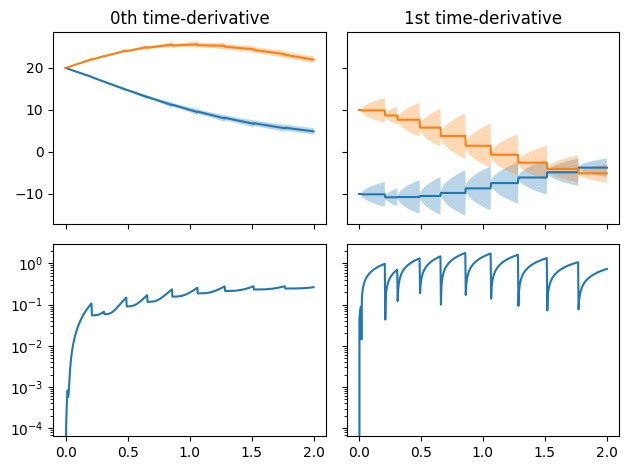

In [5]:
_, num_derivatives, _ = solution.filtered.mean.shape


fig, axes_all = plt.subplots(
    nrows=2, ncols=num_derivatives, sharex=True, sharey="row", tight_layout=True
)

for i, axes_cols in enumerate(axes_all.T):
    ms = solution.filtered.mean[:, i, :]
    ls = solution.filtered.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st time-derivative")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd time-derivative")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd time-derivative")
    else:
        axes_cols[0].set_title(f"{i}th time-derivative")

    axes_cols[0].plot(solution.t, ms)
    for m in ms.T:
        axes_cols[0].fill_between(solution.t, m - 3 * stds, m + 3 * stds, alpha=0.3)

    axes_cols[1].semilogy(solution.t, stds)

plt.show()